In [1]:
# !pip install geopy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from geopy.distance import geodesic

In [3]:
df = pd.read_csv("1_uber.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.shape


(200000, 9)

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None


In [6]:
# Convert 'pickup_datetime' to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

In [7]:
# Drop rows with missing values in 'pickup_datetime' and 'fare_amount'
df.dropna(subset=['pickup_datetime', 'fare_amount'], inplace=True)

In [8]:
# Remove negative and extremely high values in 'fare_amount' and 'passenger_count'
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

In [9]:
df.shape

(199178, 9)

In [10]:
# Extract date and time features from 'pickup_datetime'

df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_year'] = df['pickup_datetime'].dt.year

In [11]:
print(df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].isnull().sum())

pickup_latitude      0
pickup_longitude     0
dropoff_latitude     0
dropoff_longitude    0
dtype: int64


In [12]:
# Filter out rows with invalid latitude or longitude
df = df[(df['pickup_latitude'].between(-90, 90)) & 
        (df['pickup_longitude'].between(-180, 180)) &
        (df['dropoff_latitude'].between(-90, 90)) &
        (df['dropoff_longitude'].between(-180, 180))]


In [13]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day,pickup_month,pickup_year
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014


In [14]:
df.shape

(199166, 13)

In [15]:
def calculate_distance(row):
    try:
        return geodesic(
            (row['pickup_latitude'], row['pickup_longitude']),
            (row['dropoff_latitude'], row['dropoff_longitude'])
        ).km
    except ValueError as e:
        print(f"Error calculating distance for row {row.name}: {e}")
        return None  # or 0, depending on how you want to handle errors

df['distance_km'] = df.apply(calculate_distance, axis=1)

In [16]:
df = df[df['distance_km'] > 0]
df = df[df['distance_km'] < 100]

In [17]:
df.shape

(193115, 14)

In [18]:
df.drop(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)

In [19]:
df


,Unnamed: 0,fare_amount,passenger_count,pickup_hour,pickup_day,pickup_month,pickup_year,distance_km
0,24238194,7.5,1,19,7,5,2015,1.681111
1,27835199,7.7,1,20,17,7,2009,2.454363
2,44984355,12.9,1,21,24,8,2009,5.039603
3,25894730,5.3,3,8,26,6,2009,1.661442
4,17610152,16.0,5,17,28,8,2014,4.483730
...,...,...,...,...,...,...,...,...
199995,42598914,3.0,1,10,28,10,2012,0.112128
199996,16382965,7.5,1,1,14,3,2014,1.879635
199997,27804658,30.9,2,0,29,6,2009,12.867916
199998,20259894,14.5,1,14,20,5,2015,3.536552


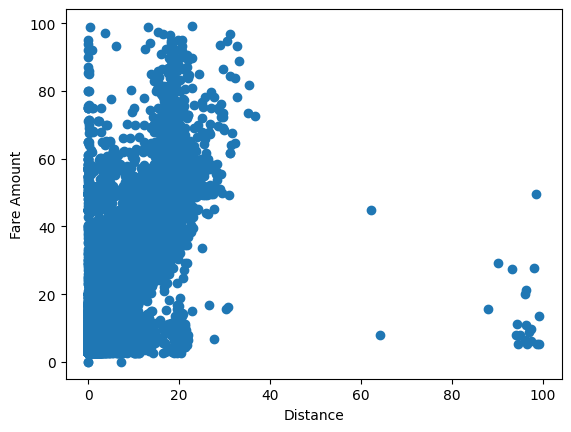

In [20]:
plt.scatter(df["distance_km"], df["fare_amount"])
plt.xlabel("Distance")
plt.ylabel("Fare Amount")
plt.show()

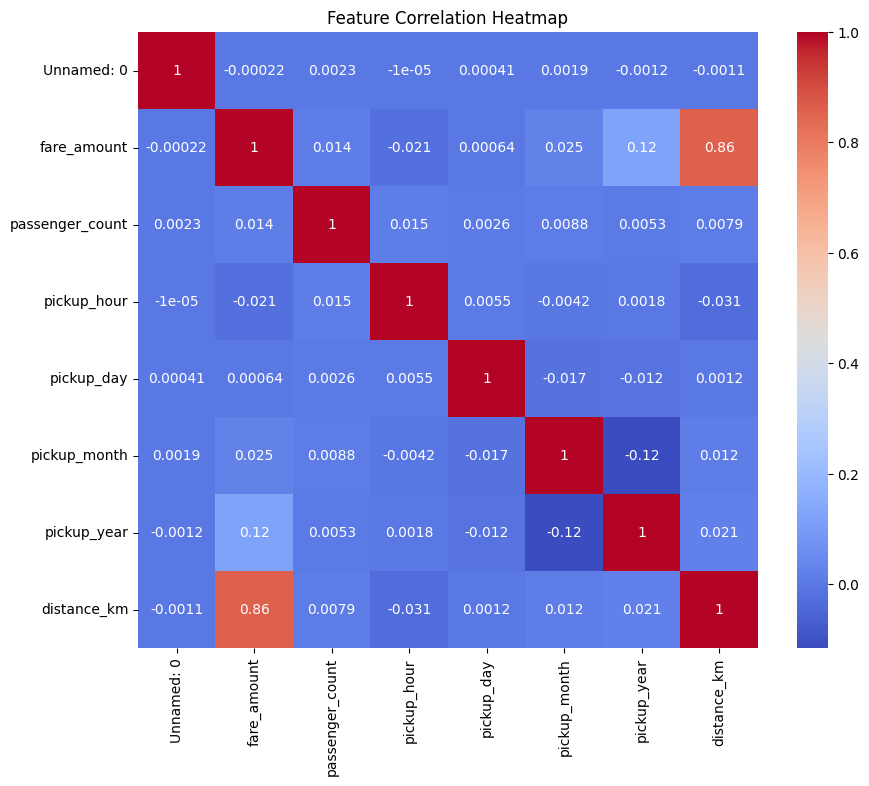

In [21]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [22]:
# 4. Implement Linear Regression and Random Forest Regression models
# Define features and target variable
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Initialize and train the Linear Regression model

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [25]:
# Initialize and train the Random Forest Regression model

random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [26]:
# Predict on test set

y_pred_linear = linear_model.predict(X_test)
y_pred_rf = random_forest_model.predict(X_test)

In [27]:
# Calculate evaluation metrics

def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

In [28]:
# Linear Regression evaluation
r2_linear, rmse_linear = evaluate_model(y_test, y_pred_linear)
print("Linear Regression:")
print(f"R^2 Score: {r2_linear:.4f}")
print(f"RMSE: {rmse_linear:.4f}")

# Random Forest Regression evaluation
r2_rf, rmse_rf = evaluate_model(y_test, y_pred_rf)
print("\nRandom Forest Regression:")
print(f"R^2 Score: {r2_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")

Linear Regression:
R^2 Score: 0.7615
RMSE: 4.4956

Random Forest Regression:
R^2 Score: 0.8139
RMSE: 3.9708


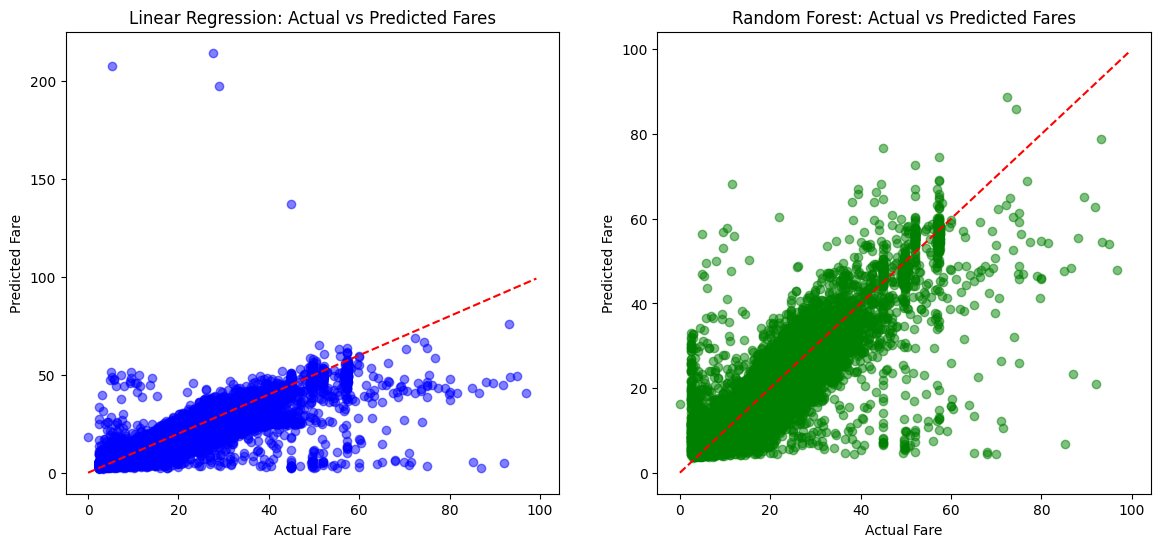

In [29]:
plt.figure(figsize=(14, 6))
# Linear Regression Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Linear Regression: Actual vs Predicted Fares")

# Random Forest Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Random Forest: Actual vs Predicted Fares")

plt.show()